In [2]:
from IPython.display import display_latex
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sympy
#sympy.init_session()
import scipy
from scipy.optimize import fsolve, root
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize
from sklearn import tree


## Exercise 2.1

### 2.1.a

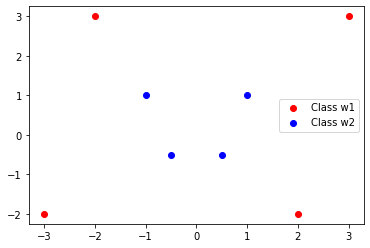

Not linearly separable


array([[ 1.        ,  3.        ,  3.        ,  4.33333333],
       [ 1.        ,  2.        , -2.        ,  1.        ],
       [ 1.        , -3.        , -2.        ,  2.66666667],
       [ 1.        , -2.        ,  3.        ,  2.66666667],
       [ 1.        ,  1.        ,  1.        , -1.        ],
       [ 1.        ,  0.5       , -0.5       , -1.5       ],
       [ 1.        , -0.5       , -0.5       , -1.5       ],
       [ 1.        , -1.        ,  1.        , -1.        ]])

In [2]:
X_test = np.array([[3, 3], [2, -2], [-3, -2], [-2, 3],
        [1, 1], [0.5, -0.5], [-0.5, -0.5], [-1, 1]])

y_test = np.array([-1, -1, -1, -1, 
           1, 1, 1, 1])

# 2.1.a
w1 = [plt.scatter(x[0], x[1], color='red') for x, y in zip(X_test, y_test) if y == -1]
w2 = [plt.scatter(x[0], x[1], color='blue') for x, y in zip(X_test, y_test) if y == 1]

plt.legend([w1[0], w2[0]], ['Class w1', 'Class w2'])
plt.show()

print("Not linearly separable")

def phi_2(x):
    return [1, x[0], x[1], (x[0]**2 + x[1]**2 - 5)/3]

X_test_4d = np.array([phi_2(x) for x in X_test])
X_test_4d

### 2.1.b

In [3]:
def dot_product(a, b):
    return sum(a_i * b_i for a_i, b_i in zip(a, b))

def show_equations(func, variables):
    derivatives = [sympy.diff(func, v) for v in variables]
    equations = [sympy.Eq(d, 0) for d in derivatives]
    
    print("The equations for the optimization are:")
    for eq in equations:
       display_latex(eq)

weights = [sympy.symbols('w%d' % i) for i in range(len(X_test_4d[0]))]
lagrange_coeffs = [sympy.symbols('a%d' % i) for i in range(len(y_test))]

# General form
print("The objective function L(w, a) is:")
obj_func = sum(w**2 for w in weights[1:]) / 2 - \
    sum(lagrange_coeffs[i] * (y_test[i] * dot_product(weights, X_test_4d[i]) - 1) for i in range(len(y_test)))

display_latex(obj_func)
show_equations(obj_func, weights)

# Objective function for lagrange multipliers
print("The objective function L(a) is:")
obj_func_lagrange = sum(lagrange_coeffs) - \
    1/2 * sum(sum(a_k * a_j * z_k * z_j * dot_product(y_k, y_j) for a_j, z_j, y_j in zip(lagrange_coeffs, y_test, X_test_4d)) for a_k, z_k, y_k in zip(lagrange_coeffs, y_test, X_test_4d))

display_latex(obj_func_lagrange)
display_latex(show_equations(obj_func_lagrange, lagrange_coeffs))

The objective function L(w, a) is:


The equations for the optimization are:


The objective function L(a) is:


The equations for the optimization are:


In [4]:
def neg_lagrange_dual(alpha, y, z):
    lagrange_sum = sum(alpha)
    double_sum = sum(sum(a_k * a_j * z_k * z_j * dot_product(y_k, y_j) for a_j, z_j, y_j in zip(alpha, z, y)) for a_k, z_k, y_k in zip(alpha, z, y))
    return 1/2 * double_sum - lagrange_sum


def optimize_alpha(x, z, C):
    m, n = x.shape
    np.random.seed(1)
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*C
    # Define the constraint
    linear_constraint = LinearConstraint(z, [0], [0])
    # Define the bounds
    bounds_alpha = Bounds(np.zeros(m), np.full(m, C))
    # Find the optimal value of alpha
    result = minimize(neg_lagrange_dual, alpha_0, args = (x, z), method='trust-constr', 
                      hess=BFGS(), constraints=[linear_constraint],
                      bounds=bounds_alpha)
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha

print("The Lagrange multipliers are:")
alphas = optimize_alpha(X_test_4d, y_test, 1e5)
print(alphas)

The Lagrange multipliers are:
[9.83276794e-08 1.61395422e-01 2.02033019e-08 8.55180768e-02
 1.64260475e-01 3.98369893e-02 2.07820143e-02 2.20341396e-02]


### 2.1.c

In [5]:
def calc_weights(x, z, alpha):
    return sum(a_k * z_k * y_k for a_k, z_k, y_k in zip(alpha, z, x))

print("The weights are:")
weights = calc_weights(X_test_4d, y_test, alphas)
print(weights)
print()

print("The values of z_k * w * y_k are:")
for z_k, y_k in zip(y_test, X_test_4d):
    print(z_k * dot_product(weights, y_k))

The weights are:
[-3.46944695e-17 -1.10325508e-06  2.22221472e-01 -6.66667227e-01]

The values of z_k * w * y_k are:
2.2222302096572193
1.1111123779065846
2.222218906484474
1.111112648528486
0.8888875958991169
0.8888895526193308
0.8888906558744153
0.8888898024092857


### 2.1.d

In [6]:
def get_margin(alpha, t, x, w, C):
    ZERO = 1e-6
    C_numeric = C-ZERO
    # Indices of support vectors with alpha<C
    ind_sv = np.where((alpha > ZERO)&(alpha < C_numeric))[0]
    w0 = 0.0
    for s in ind_sv:
        w0 = w0 + t[s] - np.dot(x[s, :], w)
    # Take the average    
    w0 = w0 / len(ind_sv)
    return w0

b = get_margin(alphas, y_test, X_test_4d, weights, 1e5)
print(b)

0.11111123660548698


### 2.1.e

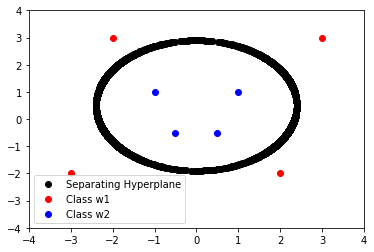

In [7]:
def classifier(x):
    return [np.dot(weights, phi_2(x)) + b, 0]

def get_hyperplane(w, w0):
    x1 = np.linspace(-1, 1, 100)
    x2 = np.linspace(-1, 1, 100)
    xx1, xx2 = np.meshgrid(x1, x2)

    roots = []
    for x, y in zip(xx1.ravel(), xx2.ravel()):
        sol = fsolve(classifier, [x, y])
        roots.append(sol)
    x_roots = np.array([r[0] for r in roots])
    y_roots = np.array([r[1] for r in roots])
    return plt.scatter(x_roots, y_roots, color='black')

g = plot_hyperplane(weights, b)
w1 = [plt.scatter(x[0], x[1], color='red') for x, y in zip(X_test, y_test) if y == -1]
w2 = [plt.scatter(x[0], x[1], color='blue') for x, y in zip(X_test, y_test) if y == 1]

plt.legend([g, w1[0], w2[0]], ['Separating Hyperplane', 'Class w1', 'Class w2'])
lim = (-4, 4)
plt.xlim(lim)
plt.ylim(lim)
plt.show()

### 2.1.st

In [8]:
def support_vectors(X, alphas):
    ZERO = 1e-6
    return [x for x,a in zip(X, alphas) if a > ZERO]
    
print(support_vectors(X_test, alphas))         

[array([ 2., -2.]), array([-2.,  3.]), array([1., 1.]), array([ 0.5, -0.5]), array([-0.5, -0.5]), array([-1.,  1.])]


### 2.1.z

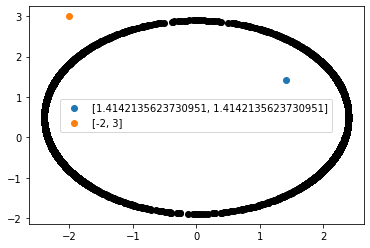

In [9]:
points = [[np.sqrt(2), np.sqrt(2)], [-2, 3]]

plot_hyperplane(weights, b)
for x in points:
    plt.scatter(x[0], x[1], label=str(x))
plt.legend()
plt.show()

## Exercise 2.3

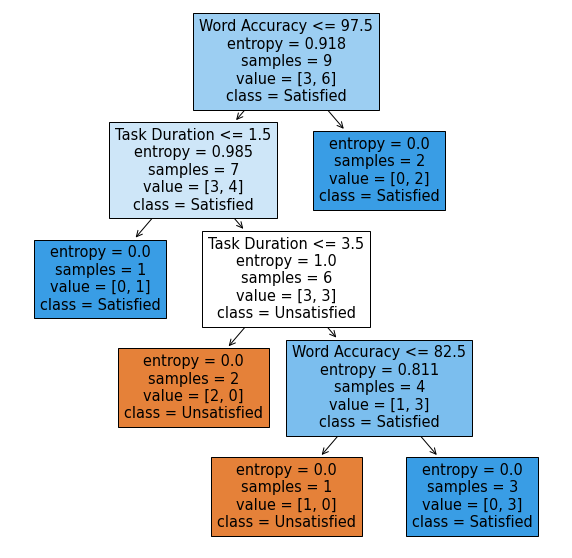

In [16]:
filename = 'cart_data.txt'
with open(filename, 'r') as f:
    lines = f.readlines()

data = [line.split() for line in lines]
y_train = [x[0] for x in data]
for y in y_train:
    if y == 'Y':
        y = 1
    else:
        y = 0

X_train = [x[1:] for x in data]
for x in X_train:
    x[0] = int(x[0])
    x[2] = int(x[2])
    if x[1] == 'Y':
        x[1] = 1
    else:
        x[1] = 0

clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train, y_train)

# Create subplots  
fig, ax = plt.subplots(1, figsize=(10, 10))
tree.plot_tree(clf, class_names=['Unsatisfied', 'Satisfied'], feature_names=['Word Accuracy', 'Task Completion', 'Task Duration'], filled=True, ax=ax)

pass